In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
! pip install mplfinance
! pip install pandas_ta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=090d48d809f098cb700543448d8144b7d0bc7de27a5bcd4411b0070b60ed1e7d
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [3]:
data = pd.read_csv('/kaggle/input/eurusd/EURUSD-30-DS.csv', header=None, names=['Date','Open', 'High', 'Low', 'Close','Volume'])
data.head()

,Date,Open,High,Low,Close,Volume
0,01.01.2008 02:00:00.000,1.45841,1.45982,1.45770,1.45937,6473.2500
1,01.01.2008 02:30:00.000,1.45965,1.45982,1.45768,1.45785,6484.6000
2,01.01.2008 03:00:00.000,1.45788,1.45803,1.45761,1.45784,4957.6000
3,01.01.2008 03:30:00.000,1.45788,1.45794,1.45754,1.45770,3416.5500
4,01.01.2008 04:00:00.000,1.45770,1.45983,1.45766,1.45954,5553.4375


In [4]:
import pandas_ta as ta
data['RSI_14'] = ta.rsi(data['Close'], length=14)
data['RSI_7'] = ta.rsi(data['Close'], length=7)
data['RSI_20'] = ta.rsi(data['Close'], length=20)
data['MA20'] = ta.ema(data['Close'], length=20)
data['MACD'] = ta.macd(data['Close'])['MACD_12_26_9']
data['ATR'] = ta.atr(data['High'], data['Low'], data['Close'], length=14)
bb = ta.bbands(data['Close'], length=20)
data['BB_upper'] = bb['BBU_20_2.0']
data['BB_lower'] = bb['BBL_20_2.0']
data['Stoch_K'] = ta.stoch(data['High'], data['Low'], data['Close'])['STOCHk_14_3_3']
data['Candle_Range'] = data['High'] - data['Low']
data['Candle_Body'] = data['Close'] - data['Open']

data = data.dropna()

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [5]:
data.head()

,Date,Open,High,Low,Close,Volume,RSI_14,RSI_7,RSI_20,MA20,MACD,ATR,BB_upper,BB_lower,Stoch_K,Candle_Range,Candle_Body
25,01.01.2008 14:30:00.000,1.45891,1.45915,1.45847,1.45880,18006.2910,47.685991,47.823801,47.680448,1.458881,-0.000093,0.000895,1.459921,1.458140,32.524272,0.00068,-0.00011
26,01.01.2008 15:00:00.000,1.45883,1.45904,1.45828,1.45853,19194.9815,44.445352,40.173630,45.267104,1.458847,-0.000110,0.000884,1.459921,1.458087,28.964401,0.00076,-0.00030
27,01.01.2008 15:30:00.000,1.45867,1.45899,1.45844,1.45872,21040.4470,47.166330,47.118547,47.245023,1.458835,-0.000107,0.000856,1.459918,1.458069,32.069953,0.00055,0.00005
28,01.01.2008 16:00:00.000,1.45877,1.45918,1.45846,1.45875,23042.9375,47.602711,48.225688,47.559992,1.458827,-0.000101,0.000845,1.459798,1.458086,36.295565,0.00072,-0.00002
29,01.01.2008 16:30:00.000,1.45893,1.45903,1.45844,1.45873,21636.3940,47.322095,47.452975,47.361558,1.458818,-0.000097,0.000825,1.459699,1.458096,47.385701,0.00059,-0.00020


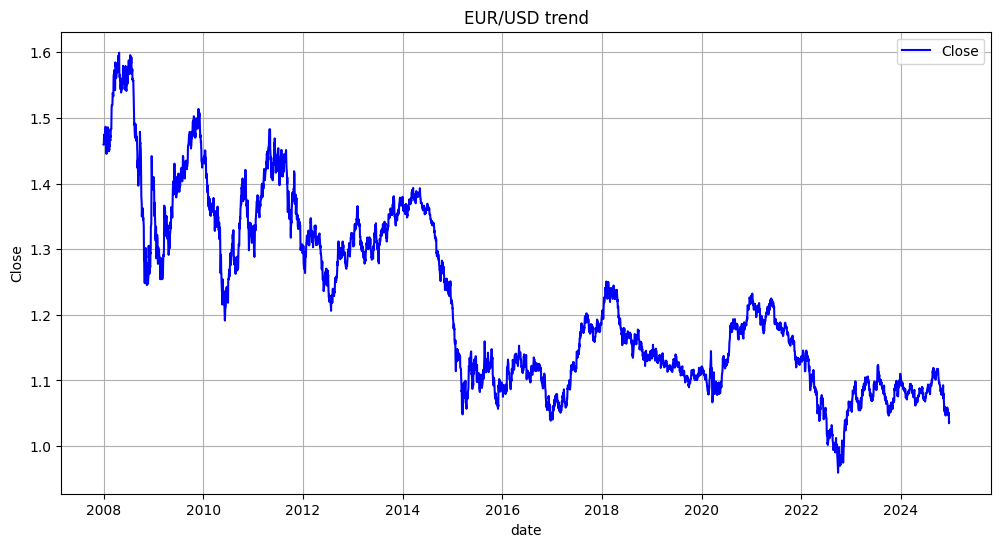

In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S.%f')
df['Day'] = df['Date'].dt.date
daily_data = df.groupby('Day').first().reset_index()  # اولین نمونه هر روز

# 4. رسم Line Plot برای Close
plt.figure(figsize=(12, 6))
plt.plot(daily_data['Date'], daily_data['Close'], label='Close', color='blue')

# 5. تنظیمات نمودار
plt.title('EUR/USD trend')
plt.xlabel('date')
plt.ylabel('Close')
plt.legend()
plt.grid(True)

# 6. نمایش
plt.show()

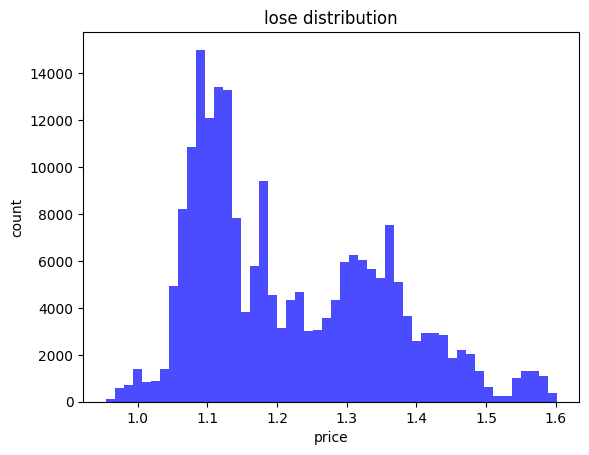

In [5]:
plt.hist(df['Close'], bins=50, color='blue', alpha=0.7)
plt.title('lose distribution')
plt.xlabel('price')
plt.ylabel('count')
plt.show()

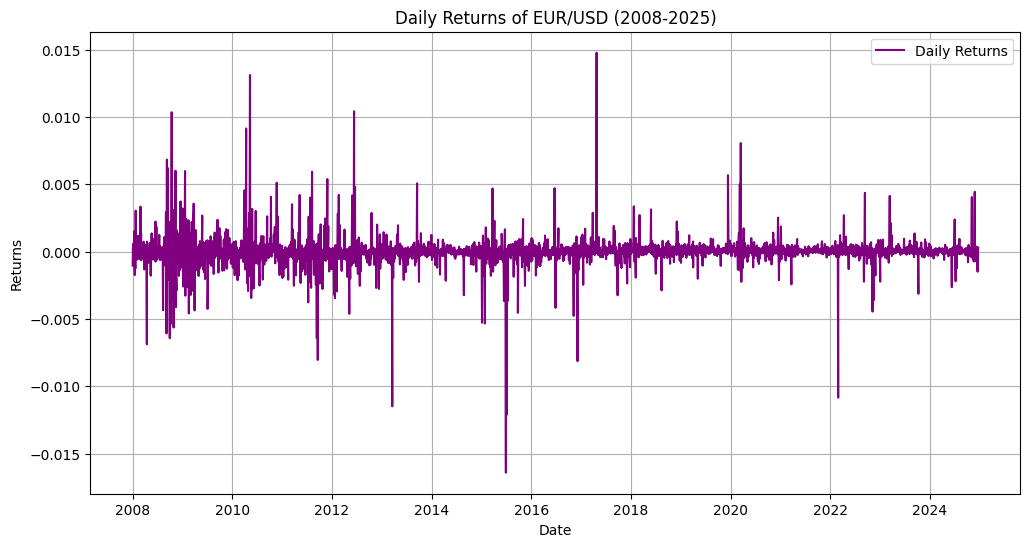

In [6]:
# Ensure 'Returns' is calculated only if not already present
if 'Returns' not in df.columns:
    df['Returns'] = df['Close'].pct_change()

if 'Returns' not in daily_data.columns:
    daily_data['Returns'] = daily_data['Close'].pct_change()

# Plotting daily returns
plt.figure(figsize=(12, 6))
plt.plot(daily_data['Day'], daily_data['Returns'], label='Daily Returns', color='purple')
plt.title('Daily Returns of EUR/USD (2008-2025)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()

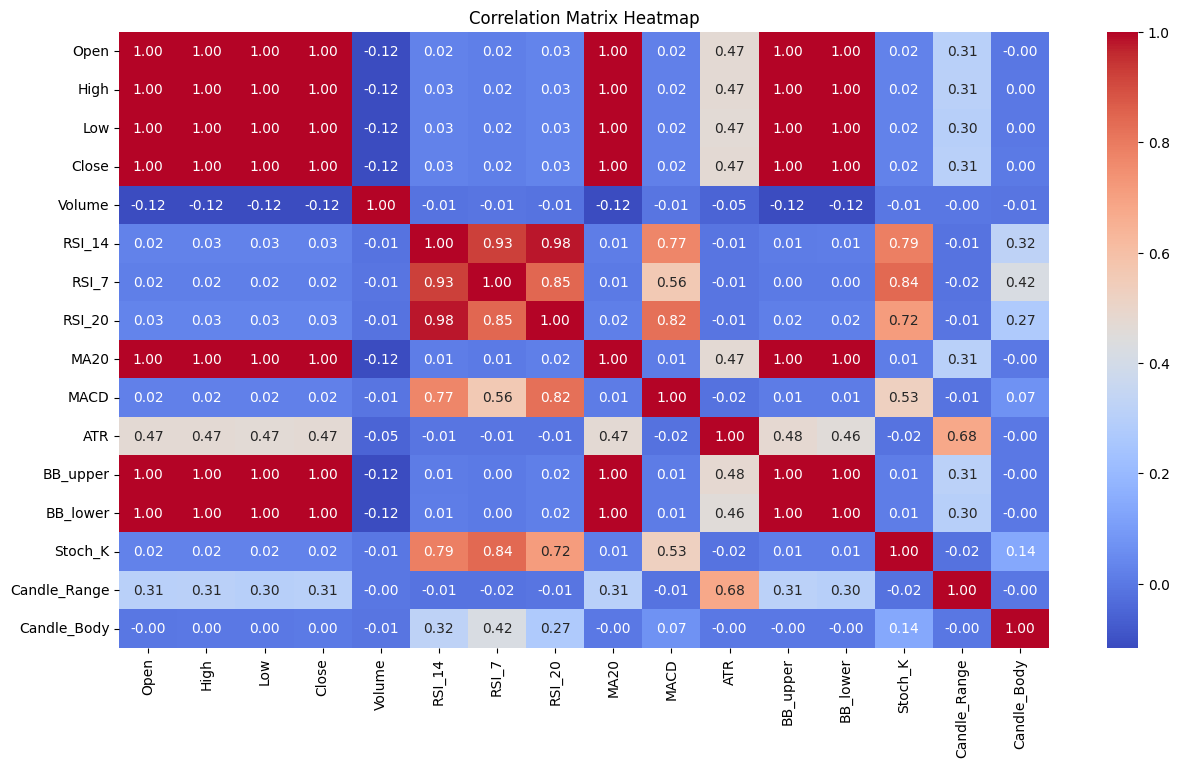

In [6]:
import seaborn as sns
correlation_matrix = data[['Open', 'High', 'Low', 'Close', 'Volume', 'RSI_14', 'RSI_7',
       'RSI_20', 'MA20', 'MACD', 'ATR', 'BB_upper', 'BB_lower', 'Stoch_K',
       'Candle_Range', 'Candle_Body']].corr()
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


In [7]:
input_features = ['Close',  'RSI_14', 'RSI_7',
       'RSI_20', 'MA20', 'MACD', 'ATR', 'BB_upper', 'BB_lower', 'Stoch_K',
       'Candle_Range', 'Candle_Body']
scalers_inputs = {col: MinMaxScaler() for col in input_features}
scaled_inputs = np.array([scalers_inputs[col].fit_transform(data[col].values.reshape(-1, 1)) for col in input_features])
scaled_inputs = np.transpose(scaled_inputs, (1, 0, 2))

# 3. انتخاب تارگت (OHLC)
output_features = ['Open', 'High', 'Low', 'Close']
scalers_outputs = {col: MinMaxScaler() for col in output_features}
scaled_outputs = np.array([scalers_outputs[col].fit_transform(data[col].values.reshape(-1, 1)) for col in output_features])
scaled_outputs = np.transpose(scaled_outputs, (1, 0, 2))

In [8]:
def create_sequences(inputs, outputs, seq_length):
    X, y = [], []
    for i in range(len(inputs) - seq_length):
        X.append(inputs[i:i + seq_length])
        y.append(outputs[i + seq_length])  # 4 مقدار OHLC تایم‌فریم بعدی
    return np.array(X), np.array(y)

seq_length = 90
X, y = create_sequences(scaled_inputs, scaled_outputs, seq_length)

In [9]:
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

print("تعداد نمونه‌های Train:", len(X_train))
print("تعداد نمونه‌های Validation:", len(X_val))
print("تعداد نمونه‌های Test:", len(X_test))

تعداد نمونه‌های Train: 169444
تعداد نمونه‌های Validation: 21180
تعداد نمونه‌های Test: 21182


In [10]:
#from tensorflow.keras.optimizers import Adam
#model = Sequential()
#model.add(LSTM(100, return_sequences=True, input_shape=(60, len(input_features))))
#odel.add(Dropout(0.3))
#model.add(LSTM(50, return_sequences=True))
#model.add(Dropout(0.3))
#model.add(LSTM(25, return_sequences=False))
#model.add(Dropout(0.3))
#model.add(Dense(4))
#model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# ایجاد مدل LSTM بهینه‌شده
model = Sequential([
    LSTM(200, return_sequences=True, input_shape=(90, len(input_features))),  # افزایش Sequence Length
    Dropout(0.4),  # افزایش Dropout
    BatchNormalization(),

    LSTM(100, return_sequences=True),
    Dropout(0.4),
    BatchNormalization(),

    LSTM(50, return_sequences=False),
    Dropout(0.4),

    Dense(25, activation='relu'),  # اضافه کردن Dense با ReLU
    Dense(4)  # خروجی یک مقدار عددی
])

optimizer = Adam(learning_rate=0.0005)

# استفاده از Huber Loss به جای MSE
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_val, y_val), callbacks=[early_stop])



Epoch 1/50
5296/5296 ━━━━━━━━━━━━━━━━━━━━ 116s 21ms/step - loss: 0.0112 - mae: 0.0623 - val_loss: 0.0030 - val_mae: 0.0419
Epoch 2/50
5296/5296 ━━━━━━━━━━━━━━━━━━━━ 109s 21ms/step - loss: 0.0012 - mae: 0.0242 - val_loss: 0.0026 - val_mae: 0.0313
Epoch 3/50
5296/5296 ━━━━━━━━━━━━━━━━━━━━ 109s 21ms/step - loss: 2.5313e-04 - mae: 0.0118 - val_loss: 0.0022 - val_mae: 0.0267
Epoch 4/50
5296/5296 ━━━━━━━━━━━━━━━━━━━━ 109s 21ms/step - loss: 1.5532e-04 - mae: 0.0092 - val_loss: 0.0021 - val_mae: 0.0272
Epoch 5/50
5296/5296 ━━━━━━━━━━━━━━━━━━━━ 109s 20ms/step - loss: 1.1351e-04 - mae: 0.0079 - val_loss: 0.0018 - val_mae: 0.0228
Epoch 6/50
5296/5296 ━━━━━━━━━━━━━━━━━━━━ 108s 20ms/step - loss: 9.2999e-05 - mae: 0.0070 - val_loss: 0.0018 - val_mae: 0.0228
Epoch 7/50
5296/5296 ━━━━━━━━━━━━━━━━━━━━ 108s 20ms/step - loss: 7.8181e-05 - mae: 0.0065 - val_loss: 0.0016 - val_mae: 0.0205
Epoch 8/50
5296/5296 ━━━━━━━━━━━━━━━━━━━━ 108s 20ms/step - loss: 9.6848e-05 - mae: 0.0069 - val_loss: 0.0014 - val_mae:

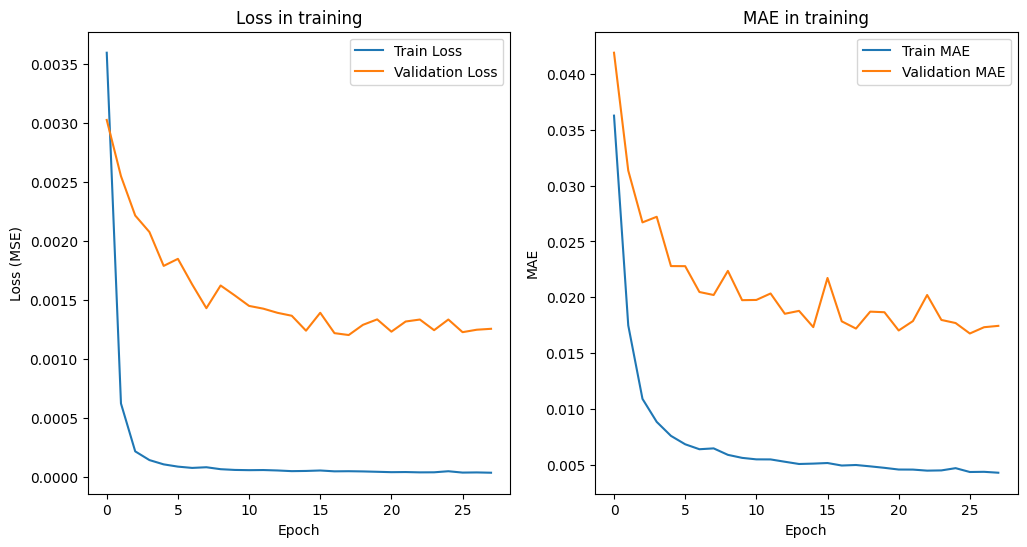

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss in training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE in training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

662/662 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

معیارهای ارزیابی برای Open:
MSE: 2.3168080864741338e-06
RMSE: 0.0015221064635806965
MAE: 0.0010965485963847525
R² Score: 0.9917930302914825

معیارهای ارزیابی برای High:
MSE: 2.4010448581637144e-06
RMSE: 0.0015495305283096924
MAE: 0.0010751558102706864
R² Score: 0.991476623868031

معیارهای ارزیابی برای Low:
MSE: 2.7293650549811866e-06
RMSE: 0.0016520790099087835
MAE: 0.0012494625669556272
R² Score: 0.9903468374229589

معیارهای ارزیابی برای Close:
MSE: 2.7299692521840107e-06
RMSE: 0.0016522618594472277
MAE: 0.0012091809430778352
R² Score: 0.9903320260916249

دقت جهت برای Close: 47.622869552901186%


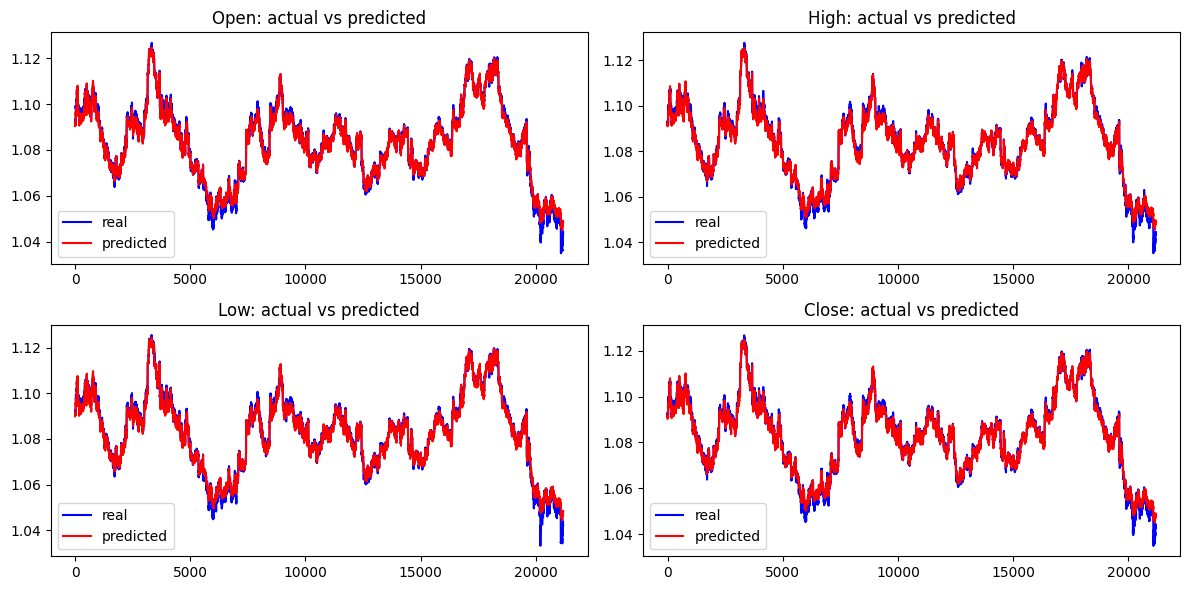

In [13]:
# 9. پیش‌بینی
predictions = model.predict(X_test)

# 10. برگردوندن به مقیاس اصلی
predictions_open = scalers_outputs['Open'].inverse_transform(predictions[:, 0].reshape(-1, 1))
predictions_high = scalers_outputs['High'].inverse_transform(predictions[:, 1].reshape(-1, 1))
predictions_low = scalers_outputs['Low'].inverse_transform(predictions[:, 2].reshape(-1, 1))
predictions_close = scalers_outputs['Close'].inverse_transform(predictions[:, 3].reshape(-1, 1))

y_test_open = scalers_outputs['Open'].inverse_transform(y_test[:, 0].reshape(-1, 1))
y_test_high = scalers_outputs['High'].inverse_transform(y_test[:, 1].reshape(-1, 1))
y_test_low = scalers_outputs['Low'].inverse_transform(y_test[:, 2].reshape(-1, 1))
y_test_close = scalers_outputs['Close'].inverse_transform(y_test[:, 3].reshape(-1, 1))

# 11. محاسبه معیارها برای هر مقدار
def calculate_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nمعیارهای ارزیابی برای {name}:")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R² Score: {r2}")

calculate_metrics(y_test_open, predictions_open, "Open")
calculate_metrics(y_test_high, predictions_high, "High")
calculate_metrics(y_test_low, predictions_low, "Low")
calculate_metrics(y_test_close, predictions_close, "Close")

# 12. دقت جهت برای Close
correct_directions = np.sum(np.sign(predictions_close[1:] - predictions_close[:-1]) == np.sign(y_test_close[1:] - y_test_close[:-1]))
directional_accuracy = correct_directions / (len(predictions_close) - 1)
print(f"\nدقت جهت برای Close: {directional_accuracy * 100}%")

# 13. رسم پیش‌بینی‌ها
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(y_test_open, label='real', color='blue')
plt.plot(predictions_open, label='predicted', color='red')
plt.title('Open: actual vs predicted')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(y_test_high, label='real', color='blue')
plt.plot(predictions_high, label='predicted', color='red')
plt.title('High: actual vs predicted')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(y_test_low, label='real', color='blue')
plt.plot(predictions_low, label='predicted', color='red')
plt.title('Low: actual vs predicted')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(y_test_close, label='real', color='blue')
plt.plot(predictions_close, label='predicted', color='red')
plt.title('Close: actual vs predicted')
plt.legend()

plt.tight_layout()
plt.show()

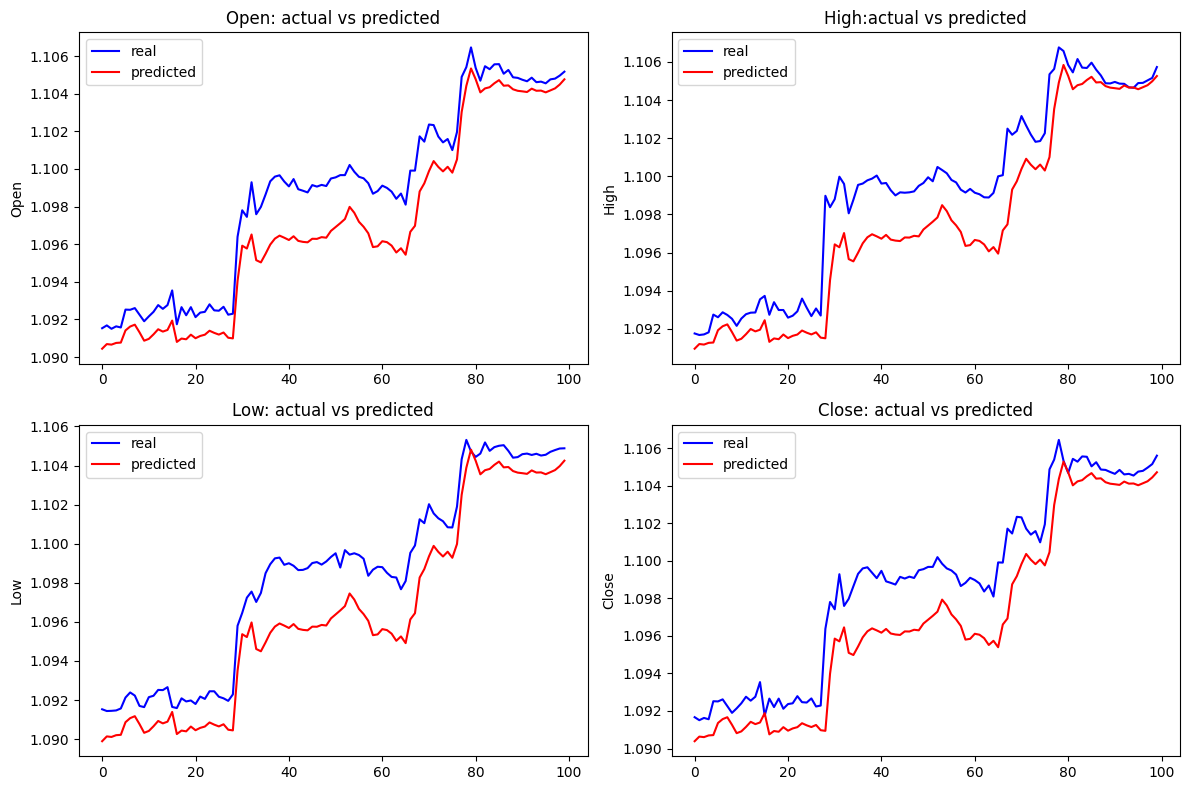

In [14]:
n_samples = 100  # تعداد نمونه‌هایی که می‌خوای نشون بدی

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(y_test_open[:n_samples], label='real', color='blue')
plt.plot(predictions_open[:n_samples], label='predicted', color='red')
plt.title('Open: actual vs predicted')
plt.ylabel('Open')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(y_test_high[:n_samples], label='real', color='blue')
plt.plot(predictions_high[:n_samples], label='predicted', color='red')
plt.title('High:actual vs predicted')
plt.ylabel('High')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(y_test_low[:n_samples], label='real', color='blue')
plt.plot(predictions_low[:n_samples], label='predicted', color='red')
plt.title('Low: actual vs predicted')
plt.ylabel('Low')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(y_test_close[:n_samples], label='real', color='blue')
plt.plot(predictions_close[:n_samples], label='predicted', color='red')
plt.title('Close: actual vs predicted')
plt.ylabel('Close')
plt.legend()

plt.tight_layout()
plt.show()

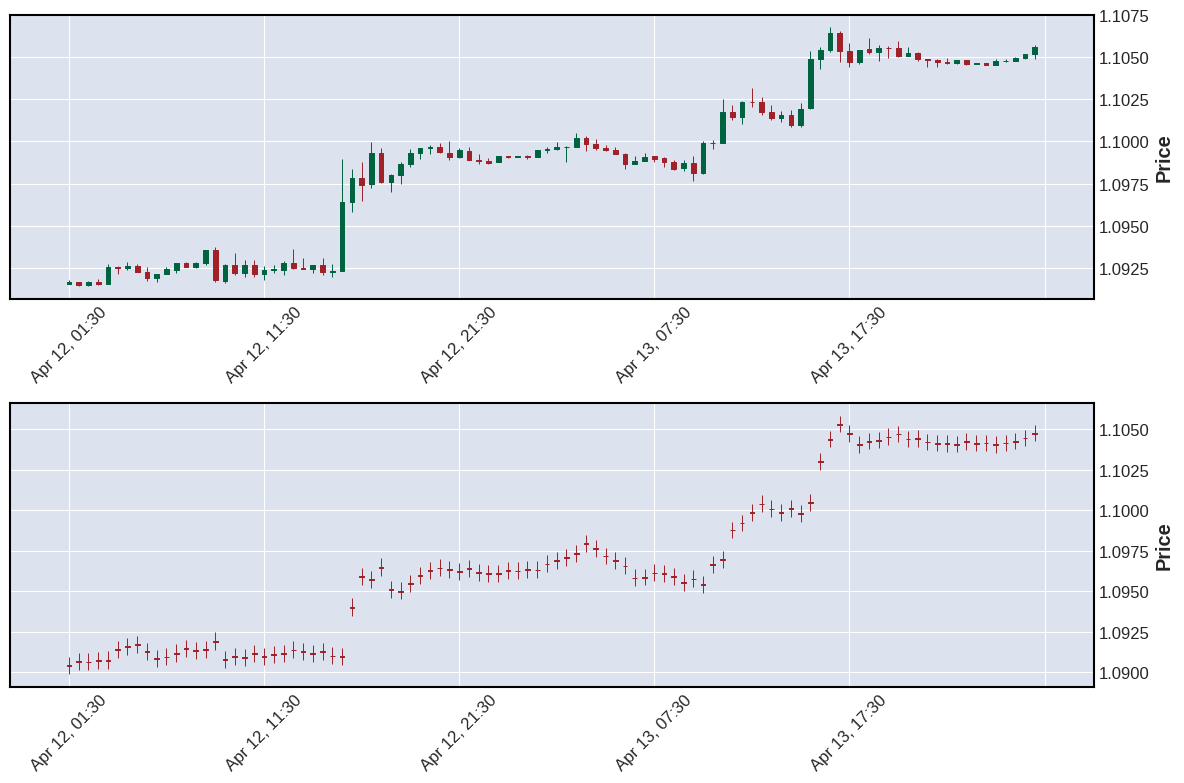

In [23]:
import mplfinance as mpf
data['Date'] = pd.to_datetime(data['Date'], format='mixed', dayfirst=True)
dates = data['Date'].iloc[-len(predictions):].values[:n_samples]
dates = pd.to_datetime(dates)  # تبدیل به datetime

predicted_candles = pd.DataFrame({
    'Date': dates,
    'Open': predictions_open[:n_samples].flatten(),
    'High': predictions_high[:n_samples].flatten(),
    'Low': predictions_low[:n_samples].flatten(),
    'Close': predictions_close[:n_samples].flatten()
})
predicted_candles.set_index('Date', inplace=True)
# مطمئن می‌شیم ایندکس DatetimeIndex باشه
predicted_candles.index = pd.DatetimeIndex(predicted_candles.index)

actual_candles = pd.DataFrame({
    'Date': dates,
    'Open': y_test_open[:n_samples].flatten(),
    'High': y_test_high[:n_samples].flatten(),
    'Low': y_test_low[:n_samples].flatten(),
    'Close': y_test_close[:n_samples].flatten()
})
actual_candles.set_index('Date', inplace=True)
# مطمئن می‌شیم ایندکس DatetimeIndex باشه
actual_candles.index = pd.DatetimeIndex(actual_candles.index)

# رسم کندل‌ها با استفاده از mpf.make_subplots
# به جای plt.subplots، از خود mplfinance برای مدیریت زیرنمودارها استفاده می‌کنیم
fig = mpf.figure(figsize=(12, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)

# رسم کندل‌های واقعی و پیش‌بینی‌شده
mpf.plot(actual_candles, type='candle', style='charles', ax=ax1)
mpf.plot(predicted_candles, type='candle', style='charles', ax=ax2)

# تنظیم فاصله بین زیرنمودارها
fig.tight_layout()
mpf.show()

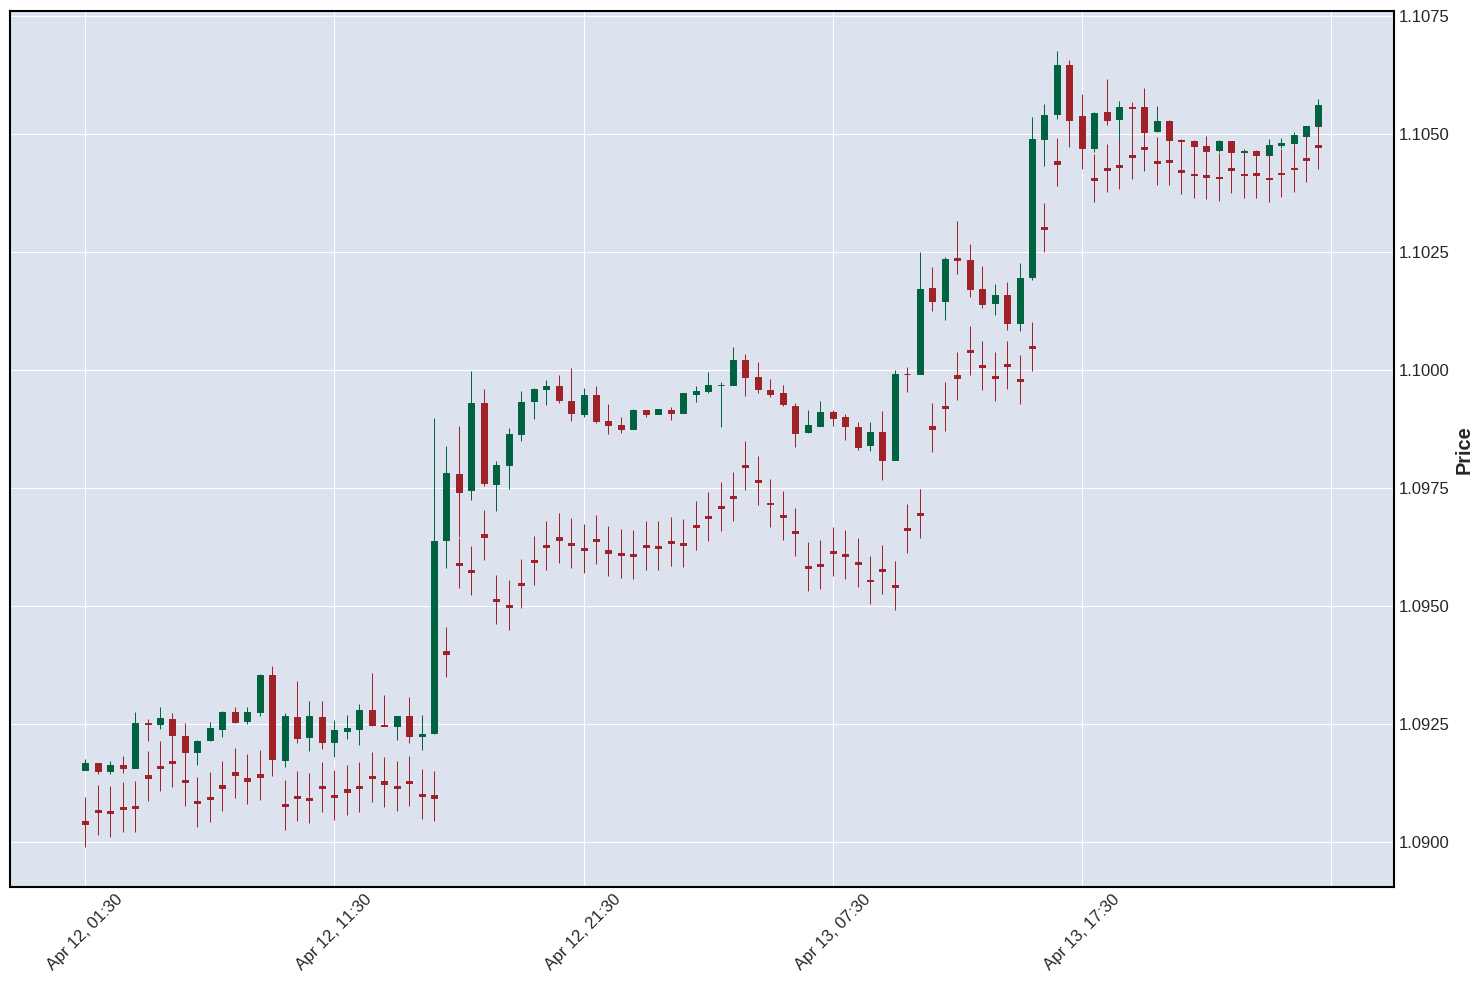

In [37]:
data['Date'] = pd.to_datetime(data['Date'], format='mixed', dayfirst=True)
dates = data['Date'].iloc[-len(predictions):].values[:n_samples]
dates = pd.to_datetime(dates)  # تبدیل به datetime

predicted_candles = pd.DataFrame({
    'Date': dates,
    'Open': predictions_open[:n_samples].flatten(),
    'High': predictions_high[:n_samples].flatten(),
    'Low': predictions_low[:n_samples].flatten(),
    'Close': predictions_close[:n_samples].flatten()
})
predicted_candles.set_index('Date', inplace=True)
# مطمئن می‌شیم ایندکس DatetimeIndex باشه
predicted_candles.index = pd.DatetimeIndex(predicted_candles.index)

actual_candles = pd.DataFrame({
    'Date': dates,
    'Open': y_test_open[:n_samples].flatten(),
    'High': y_test_high[:n_samples].flatten(),
    'Low': y_test_low[:n_samples].flatten(),
    'Close': y_test_close[:n_samples].flatten()
})
actual_candles.set_index('Date', inplace=True)
# مطمئن می‌شیم ایندکس DatetimeIndex باشه
actual_candles.index = pd.DatetimeIndex(actual_candles.index)

fig = mpf.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)

mpf.plot(actual_candles, type='candle', style='charles', ax=ax)
        

# کندل‌های پیش‌بینی‌شده (پررنگ) روی همون محور
mpf.plot(predicted_candles, type='candle', style='charles', ax=ax)        


# نمایش نمودار
fig.tight_layout()
mpf.show()